In [1]:
from pyrplidar import PyRPlidar

def check_connection():

    lidar = PyRPlidar()
    lidar.connect(port="/dev/ttyACM1", baudrate=115200, timeout=3)
    # Linux   : "/dev/ttyUSB0"
    # MacOS   : "/dev/cu.SLAB_USBtoUART"
    # Windows : "COM5"
        
    info = lidar.get_info()
    print("info :", info)
    
    health = lidar.get_health()
    print("health :", health)
    
    samplerate = lidar.get_samplerate()
    print("samplerate :", samplerate)
    
    scan_modes = lidar.get_scan_modes()
    print("scan modes :")
    for scan_mode in scan_modes:
        print(scan_mode)

    lidar.disconnect()

if __name__ == "__main__":
    check_connection()

PyRPlidar Info : device is connected
info : {'model': 24, 'firmware_minor': 29, 'firmware_major': 1, 'hardware': 7, 'serialnumber': 'B9C2ECF0C3E09ED2A0EA98F32A1A4110'}
health : {'status': 0, 'error_code': 0}
samplerate : {'t_standard': 508, 't_express': 254}
{'name': 'Standard', 'max_distance': 3072, 'us_per_sample': 130048, 'ans_type': 'NORMAL'}
{'name': 'Express', 'max_distance': 3072, 'us_per_sample': 65024, 'ans_type': 'CAPSULED'}
{'name': 'Boost', 'max_distance': 3072, 'us_per_sample': 32512, 'ans_type': 'ULTRA_CAPSULED'}
{'name': 'Sensitivity', 'max_distance': 3072, 'us_per_sample': 32512, 'ans_type': 'ULTRA_CAPSULED'}
{'name': 'Stability', 'max_distance': 3072, 'us_per_sample': 51456, 'ans_type': 'ULTRA_CAPSULED'}
scan modes :
{'name': 'Standard', 'max_distance': 3072, 'us_per_sample': 130048, 'ans_type': 'NORMAL'}
{'name': 'Express', 'max_distance': 3072, 'us_per_sample': 65024, 'ans_type': 'CAPSULED'}
{'name': 'Boost', 'max_distance': 3072, 'us_per_sample': 32512, 'ans_type': 

In [5]:
from rplidar import RPLidar, RPLidarException
import time

PORT_NAME = '/dev/ttyACM1'

def run():
    lidar = RPLidar(PORT_NAME)
    old_t = None
    data = []

    try:
        print('Press Ctrl+C to stop')
        for scan in lidar.iter_scans():
            now = time.time()
            if old_t is None:
                old_t = now
                continue
            delta = now - old_t
            data.append(delta)

            if len(data) % 5 == 0:
                print('%.2f Hz, %.2f RPM' % (1/delta, 60/delta))

            old_t = now
            time.sleep(0.001)  # avoid buffer overflow

    except KeyboardInterrupt:
        print('Stopping. Computing mean...')
    except RPLidarException as e:
        print("LIDAR exception:", e)
    finally:
        lidar.stop()
        lidar.stop_motor()
        lidar.disconnect()

        if data:
            delta = sum(data) / len(data)
            print('Mean: %.2f Hz, %.2f RPM' % (1/delta, 60/delta))

if __name__ == '__main__':
    run()

Press Ctrl+C to stop
LIDAR exception: Wrong body size


In [6]:
#!/usr/bin/env python3
'''Records scans to a given file in the form of numpy array.
Usage example:

$ ./record_scans.py out.npy'''
import sys
import numpy as np
from rplidar import RPLidar


PORT_NAME = '/dev/ttyACM1'


def run(path):
    '''Main function'''
    lidar = RPLidar(PORT_NAME)
    data = []
    try:
        print('Recording measurments... Press Crl+C to stop.')
        for scan in lidar.iter_scans():
            data.append(np.array(scan))
    except KeyboardInterrupt:
        print('Stoping.')
    lidar.stop()
    lidar.disconnect()
    np.save(path, np.array(data))

if __name__ == '__main__':
    run(sys.argv[1])

Recording measurments... Press Crl+C to stop.
Stoping.


In [6]:
#!/usr/bin/env python3
'''Records measurments to a given file. Usage example:

$ ./record_measurments.py out.txt'''
import sys
from rplidar import RPLidar


PORT_NAME = '/dev/ttyACM1'


def run(path):
    '''Main function'''
    lidar = RPLidar(PORT_NAME)
    outfile = open(path, 'w')
    try:
        print('Recording measurments... Press Crl+C to stop.')
        for measurment in lidar.iter_scans():
            line = '\t'.join(str(v) for v in measurment)
            outfile.write(line + '\n')
    except KeyboardInterrupt:
        print('Stoping.')
    lidar.stop()
    lidar.disconnect()
    outfile.close()

if __name__ == '__main__':
    run(sys.argv[1])

Recording measurments... Press Crl+C to stop.


RPLidarException: Wrong body size

[24 points] Sample: (15, 206.765625, 668.5)


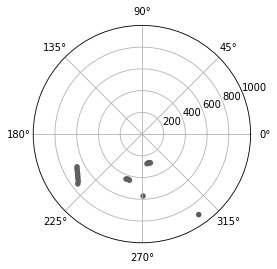

In [10]:
#!/usr/bin/env python3
'''Animates distances and measurment quality'''
from rplidar import RPLidar
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

PORT_NAME = '/dev/ttyACM1'
DMAX = 1000
IMIN = 0
IMAX = 50

def update_line(num, iterator, line):
    scan = next(iterator)
    print(f"[{len(scan)} points] Sample: {scan[0] if scan else 'No Data'}")  # ✅ DEBUG
    if not scan:
        return line,

    offsets = np.array([(np.radians(meas[1]), meas[2]) for meas in scan])
    line.set_offsets(offsets)
    intens = np.array([meas[0] for meas in scan])
    line.set_array(intens)
    return line,

def run():
    lidar = RPLidar(PORT_NAME)
    lidar.start_motor()
    fig = plt.figure()
    ax = plt.subplot(111, projection='polar')
    line = ax.scatter([0, 0], [0, 0], s=30, c=[IMIN, IMAX],
                           cmap=plt.cm.Greys_r, lw=0)
    ax.set_rmax(DMAX)
    ax.grid(True)

    iterator = lidar.iter_scans()
    ani = animation.FuncAnimation(fig, update_line,
        fargs=(iterator, line), interval=100)
    plt.show()
    lidar.stop_motor()
    lidar.stop()
    lidar.disconnect()

if __name__ == '__main__':
    run()

In [12]:
from rplidar import RPLidar
lidar = RPLidar('/dev/ttyACM1')

info = lidar.get_info()
print(info)

health = lidar.get_health()
print(health)

for i, scan in enumerate(lidar.iter_scans()):
    for quality, angle, distance in scan:
        print(f"Angle: {angle:.2f}°, Distance: {distance:.2f} mm, Quality: {quality}")

lidar.stop()
lidar.stop_motor()
lidar.disconnect()

{'model': 24, 'firmware': (1, 29), 'hardware': 7, 'serialnumber': 'B9C2ECF0C3E09ED2A0EA98F32A1A4110'}
('Good', 0)


RPLidarException: Wrong body size

In [1]:
from jetracer.nvidia_racecar import NvidiaRacecar
from rplidar import RPLidar
import time

car = NvidiaRacecar()
lidar = RPLidar('/dev/ttyACM1')

info = lidar.get_info()
print("info:", info)

health = lidar.get_health()
print("health:", health)

try:
    car.throttle = -0.5  # Start moving backward
    car.steering = 0

    state = "reversing"
    transition_time = 0

    for scan in lidar.iter_scans():
        now = time.time()

        if transition_time and now >= transition_time:
            if state == "stopping":
                car.throttle = 0.5  
                car.steering = 1 
                state = "forwarding"
                transition_time = now + 1
            elif state == "forwarding":
                car.steering = 0
                car.throttle = -0.5  
                state = "reversing"
                transition_time = 0

        for quality, angle, distance in scan:
            if 160 <= angle <= 220 and distance < 300:
                if state == "reversing":
                    print(f"Obstacle! Angle: {angle:.2f}, Distance: {distance:.2f}")
                    car.throttle = 0  # stop
                    state = "stopping"
                    transition_time = now + 0.5
                break

except KeyboardInterrupt:
    print("Stopped by user")

finally:
    car.throttle = 0
    car.steering = 0
    lidar.stop()
    lidar.stop_motor()
    lidar.disconnect()
    print("🔌 Clean shutdown")

WARNNIG: Jetson.GPIO library has not been verified with this carrier board,


info: {'model': 24, 'firmware': (1, 29), 'hardware': 7, 'serialnumber': 'B9C2ECF0C3E09ED2A0EA98F32A1A4110'}
health: ('Good', 0)
Obstacle! Angle: 161.42, Distance: 299.00
Obstacle! Angle: 161.31, Distance: 284.25
Obstacle! Angle: 160.34, Distance: 270.00
Stopped by user
🔌 Clean shutdown


In [ ]:
car.throttle = 0

In [2]:
from pyrplidar import PyRPlidar
import time

def simple_obstacle_avoidance():
    lidar = PyRPlidar()
    lidar.connect(port="/dev/ttyACM1", baudrate=115200, timeout=3)
    lidar.set_motor_pwm(500)
    time.sleep(2)

    try:
        for scan in lidar.force_scan()():
            if 160 <= scan.angle <= 220 and 10 < scan.distance < 300:
                print(f"Obstacle detected! Angle: {scan.angle:.1f}, Distance: {scan.distance}mm")
    except KeyboardInterrupt:
        print("Stopped by user.")
    finally:
        lidar.stop()
        lidar.set_motor_pwm(0)
        lidar.disconnect()

if __name__ == "__main__":
    simple_obstacle_avoidance()

PyRPlidar Info : device is connected
Obstacle detected! Angle: 161.0, Distance: 213.25mm
Obstacle detected! Angle: 161.8, Distance: 213.5mm
Obstacle detected! Angle: 163.8, Distance: 212.75mm
Obstacle detected! Angle: 165.2, Distance: 212.75mm
Obstacle detected! Angle: 166.5, Distance: 213.75mm
Obstacle detected! Angle: 167.9, Distance: 216.25mm
Obstacle detected! Angle: 168.4, Distance: 219.0mm
Obstacle detected! Angle: 213.8, Distance: 233.75mm
Obstacle detected! Angle: 216.6, Distance: 219.75mm
Obstacle detected! Angle: 212.7, Distance: 233.75mm
Obstacle detected! Angle: 216.3, Distance: 220.25mm
Obstacle detected! Angle: 217.7, Distance: 214.25mm
Obstacle detected! Angle: 213.1, Distance: 239.5mm
Obstacle detected! Angle: 215.5, Distance: 231.25mm
Obstacle detected! Angle: 218.3, Distance: 217.75mm
Obstacle detected! Angle: 215.9, Distance: 230.5mm
Obstacle detected! Angle: 215.1, Distance: 230.5mm
Obstacle detected! Angle: 214.9, Distance: 227.75mm
Obstacle detected! Angle: 217.4,

In [13]:
from jetracer.nvidia_racecar import NvidiaRacecar
from pyrplidar import PyRPlidar
import time

car = NvidiaRacecar()
lidar = PyRPlidar()
lidar.connect(port="/dev/ttyACM1", baudrate=115200, timeout=3)
lidar.set_motor_pwm(500)
time.sleep(2)

info = lidar.get_info()
print("info:", info)

health = lidar.get_health()
print("health:", health)

try:
    car.throttle = -0.5  # Start moving backward
    car.steering = 0

    state = "reversing"
    transition_time = 0

    for scan in lidar.force_scan()():
        now = time.time()

        if transition_time and now >= transition_time:
            if state == "stopping":
                car.throttle = 0.5  
                car.steering = 1 
                state = "forwarding"
                transition_time = now + 1
            elif state == "forwarding":
                car.steering = 0
                car.throttle = -0.5  
                state = "reversing"
                transition_time = 0

        if 160 <= scan.angle <= 220 and 10 < scan.distance < 300:
            if state == "reversing":
                print(f"Obstacle! Angle: {scan.angle:.2f}, Distance: {scan.distance:.2f}")
                car.throttle = 0  # stop
                state = "stopping"
                transition_time = now + 0.5

except KeyboardInterrupt:
    print("Stopped by user")

finally:
    car.throttle = 0
    car.steering = 0
    lidar.stop()
    lidar.set_motor_pwm(0)
    lidar.disconnect()
    print("🔌 Clean shutdown")

PyRPlidar Info : device is connected
info: {'model': 24, 'firmware_minor': 29, 'firmware_major': 1, 'hardware': 7, 'serialnumber': 'B9C2ECF0C3E09ED2A0EA98F32A1A4110'}
health: {'status': 0, 'error_code': 0}
Obstacle! Angle: 186.61, Distance: 150.00
Obstacle! Angle: 176.45, Distance: 223.75
Obstacle! Angle: 178.06, Distance: 226.50
Stopped by user
PyRPlidar Info : device is disconnected
🔌 Clean shutdown
